In [1]:
using Jacobi
using PyPlot
include("../../HPFEM.jl/src/HPFEM.jl");

In [2]:
M= 10
Q=M
nel = 1
nnodes = nel + 1
a=-1
b= 1
nodes = collect(linspace(a, b, nnodes));

idir = [1,nnodes]
lagr = HPFEM.Lagrange1d(M);
quad = HPFEM.QuadType(Q);
base = HPFEM.Basis1d(lagr, quad);

lmap = HPFEM.locmap(base)
dof = HPFEM.DofMap1d(lmap, nnodes, idir);

In [3]:
HPFEM.ninterior(dof.lmap)

8

# EDO 
Resolveremos a EDO com a seguinte condição de dirichlet condição de dirichlet :
\begin{align}
    y'' + y = (1 - 4 \pi^2)\ sin(2\ \pi\ x),\\
    y(-1) = sin(-2\ \pi x),\ y(1) = sin(2\ \pi\ x)
\end{align}

In [4]:
fun(x) = (1 + 4*pi^2)*sin(2*pi*x)
resp(x) = sin(2*pi*x)

resp (generic function with 1 method)

In [5]:
elemento = [HPFEM.Element1d(e, nodes[e], nodes[e+1], base) for e = 1:nel]
#solver = HPFEM.CholeskySC(dof, HPFEM.BBMatrix);
solver = HPFEM.CholeskySC(dof, HPFEM.BBSymTri);

In [6]:
for e = 1:nel
    x  = elemento[e].x
    
    Ae = HPFEM.mass_matrix(base, elemento[e])
    Se = HPFEM.stiff_matrix(base,elemento[e])
    Ae = Ae + Se
    HPFEM.add_local_matrix(solver, e, Ae)
end


In [7]:
bnd = HPFEM.bndidx(lmap)


2-element Array{Int64,1}:
  1
 10

In [8]:
Fe = zeros(HPFEM.nmodes(lmap), nel)

for e = 1:nel
    fe = fun(elemento[e].x)
    HPFEM.add_rhs!(base, elemento[e], fe, sub(Fe, :, e))
end
Fe[bnd[1],1] = resp(a)
Fe[bnd[2],nel]= resp(b)

-2.4492935982947064e-16

In [9]:
HPFEM.solve!(solver, Fe)


10x1 Array{Float64,2}:
  2.44929e-16
  0.48461    
  0.996163   
 -0.134586   
 -0.867848   
  0.867848   
  0.134586   
 -0.996163   
 -0.48461    
 -2.44929e-16

In [10]:
nξ = 101
ξ = collect(linspace(-1,1,nξ));
ϕ = zeros(nξ, M)
for i = 1:M
    ϕ[:,i] = base(ξ, i)
end

Ue = ϕ * Fe


101x1 Array{Float64,2}:
  2.44929e-16
  0.134126   
  0.258223   
  0.374009   
  0.48218    
  0.582667   
  0.674857   
  0.757781   
  0.830274   
  0.891106   
  0.93909    
  0.973172   
  0.992491   
  ⋮          
 -0.973172   
 -0.93909    
 -0.891106   
 -0.830274   
 -0.757781   
 -0.674857   
 -0.582667   
 -0.48218    
 -0.374009   
 -0.258223   
 -0.134126   
 -2.44929e-16

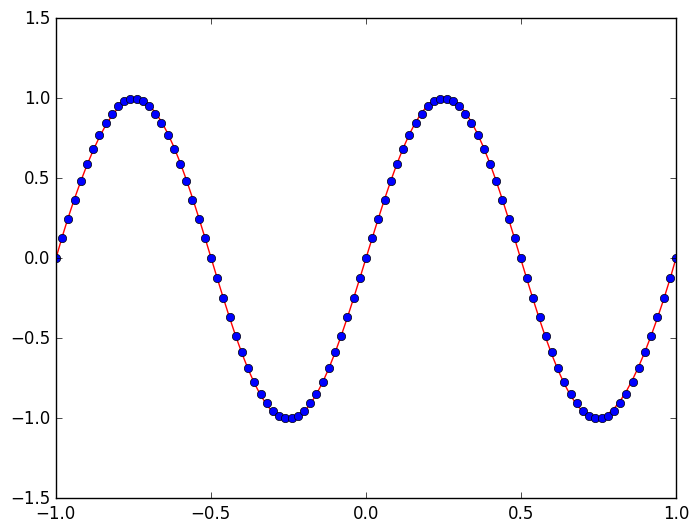

0.014708918251607916

In [11]:
using PyPlot
x = [(1-ξ)*el.a/2 + (1+ξ)*el.b/2 for el in elemento]
maxerr = -1000000
for e = 1:nel
    uu = resp(x[e])
    err = maxabs(uu-Ue[:,e])
    if err > maxerr maxerr = err end
        
    plot(x[e], Ue[:,e], "r")
    plot(x[e], uu, "ob")
end
maxerr